In [1]:
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from scipy.stats import spearmanr, kendalltau
import math
import os

In [2]:
%ls chgk

players.pkl      results.pkl      tournaments.pkl


In [3]:
with open('chgk/players.pkl', 'rb') as f:
    players = pickle.load(f)
with open('chgk/results.pkl', 'rb') as f:
    results = pickle.load(f)
with open('chgk/tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)

In [4]:
df_players = pd.DataFrame.from_dict(players, orient='index')
df_players.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [5]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204063 entries, 1 to 224704
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          204063 non-null  int64 
 1   name        204063 non-null  object
 2   patronymic  204032 non-null  object
 3   surname     204063 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.8+ MB


In [6]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index')
df_tournaments['dateStart'] = pd.to_datetime(df_tournaments['dateStart'], errors='coerce', utc=True)
df_tournaments.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-24 20:00:00+00:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-08 20:00:00+00:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-21 21:00:00+00:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-10 20:00:00+00:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-09 20:00:00+00:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [7]:
df_tournaments_train = df_tournaments[df_tournaments.dateStart.dt.year.eq(2019)]
df_tournaments_test = df_tournaments[df_tournaments.dateStart.dt.year.eq(2020)]
df_tournaments_train.shape, df_tournaments_test.shape

((689, 9), (416, 9))

In [8]:
df_tournaments_train.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
4772,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4973,4973,Балтийский Берег. 3 игра,2019-01-25 16:05:00+00:00,2019-01-29T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4974,4974,Балтийский Берег. 4 игра,2019-03-01 16:05:00+00:00,2019-03-05T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4975,4975,Балтийский Берег. 5 игра,2019-04-05 16:05:00+00:00,2019-04-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4986,4986,ОВСЧ. 6 этап,2019-02-15 17:00:00+00:00,2019-02-19T20:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}"


In [9]:
tournaments_train_ids = set(df_tournaments_train.id)

In [10]:
results_df_train = pd.DataFrame()
for index in tqdm(results):
    if index in tournaments_train_ids:
        temp_df = pd.DataFrame(results[index])
        temp_df['id_tournament'] = index
        results_df_train = pd.concat([results_df_train, temp_df])

  0%|          | 0/5528 [00:00<?, ?it/s]

In [11]:
results_df_train.head()

,team,mask,current,questionsTotal,synchRequest,position,controversials,flags,teamMembers,id_tournament
0,"{'id': 45556, 'name': 'Рабочее название', 'tow...",111111111011111110111111111100010010,"{'name': 'Рабочее название', 'town': {'id': 28...",28.0,"{'id': 56392, 'venue': {'id': 3030, 'name': 'С...",1.0,"[{'id': 91169, 'questionNumber': 15, 'answer':...",[],"[{'flag': 'Б', 'usedRating': 13507, 'rating': ...",4772
1,"{'id': 1030, 'name': 'Сборная Бутана', 'town':...",111111111011110100101111011001011010,"{'name': 'Сборная Бутана', 'town': {'id': 346,...",25.0,"{'id': 56690, 'venue': {'id': 3151, 'name': 'У...",5.5,[],[],"[{'flag': None, 'usedRating': 13058, 'rating':...",4772
2,"{'id': 4252, 'name': 'Ять', 'town': {'id': 197...",111111111011110101101111001011110000,"{'name': 'Ять', 'town': {'id': 197, 'name': 'М...",25.0,"{'id': 56814, 'venue': {'id': 3112, 'name': 'М...",5.5,"[{'id': 91164, 'questionNumber': 33, 'answer':...",[],"[{'flag': 'К', 'usedRating': 9584, 'rating': 9...",4772
3,"{'id': 5444, 'name': 'Эйфью', 'town': {'id': 1...",101111101111111110001101011001111010,"{'name': 'Эйфью', 'town': {'id': 197, 'name': ...",25.0,"{'id': 56814, 'venue': {'id': 3112, 'name': 'М...",5.5,[],[],"[{'flag': 'Л', 'usedRating': 8592, 'rating': 8...",4772
4,"{'id': 40931, 'name': 'Здоровенный Я', 'town':...",111111101011111101000111001001111110,"{'name': 'Здоровенный Я', 'town': {'id': 201, ...",25.0,"{'id': 55460, 'venue': {'id': 3117, 'name': 'М...",5.5,[],[],"[{'flag': 'Л', 'usedRating': 12069, 'rating': ...",4772


# Baseline

**Идея**: Правильно ли игрок ответит на вопрос зависит от его рейтинга и сложности вопроса. Также допустим, что если команда ответила на вопрос то все игроки ответили на вопрос.

**Постановка**: Таким образом пусть $P(x_{ij})=\sigma(r_i - c_j)$, где $r_i$ - рейтинг $i$-го игрока, $c_j$ - сложность $j$-го вопроса

In [76]:
total_num_questions = 0
id_to_players = set()
members_specific = []
questions = []
question_to_tournament = {}
answers = []
members_team = []
for tournament in tqdm(tournaments_train_ids):
    max_num_questions = 0
    for team in results[tournament]:
        if team.get('mask', None) is not None:
            bad_answers = 0
            for answer_id in range(len(team['mask'])):
                question_to_tournament[total_num_questions + answer_id] = tournament
                if team['mask'][answer_id] in ('0', '1'):
                    members = [member['player']['id'] for member in team['teamMembers']]
                    for member in members:
                        id_to_players.add(member)
                        members_specific.append(member)
                        questions.append(total_num_questions + answer_id)
                        answers.append(int(team['mask'][answer_id]))
                        members_team.append(members)
                else:
                    bad_answers += 1
            max_num_questions = max(max_num_questions, len(team['mask']) - bad_answers)
    total_num_questions += max_num_questions
id_to_players = list(id_to_players)

  0%|          | 0/689 [00:00<?, ?it/s]

In [78]:
print(f'number of questions: {total_num_questions}')
print(f'players: {len(id_to_players)}')
print(f'dataset: {len(questions)}')

number of questions: 33375
players: 59271
dataset: 21008480


In [14]:
player_to_id = {}
for i, player in enumerate(id_to_players):
    player_to_id[player] = i

In [34]:
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy
torch.manual_seed(0)

In [35]:
class Baseline(nn.Module):
    def __init__(self, num_players, num_questions):
        super().__init__()
        
        self.players_emb = nn.Embedding(num_players, 1)
        self.questions_emb = nn.Embedding(num_questions, 1)

    def forward(self, players, questions):
        players_emb = self.players_emb(players)
        questions_emb = self.questions_emb(questions)
        return torch.sigmoid(players_emb - questions_emb).squeeze(1)

In [36]:
device = torch.device("cpu")
criterion = nn.BCELoss()
accuracy = BinaryAccuracy()
members_specific_tensor = torch.LongTensor([player_to_id[member] for member in members_specific]).to(device)
questions_tensor = torch.LongTensor(questions).to(device)
answers_tensor = torch.tensor(answers, dtype=torch.float).to(device)

In [37]:
baseline = Baseline(len(player_to_id), total_num_questions).to(device)

In [38]:
def train(model, answers_tensor):
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1, history_size=100, max_iter=20, line_search_fn='strong_wolfe')
    def closure():
        optimizer.zero_grad()
        output = model(members_specific_tensor, questions_tensor)
        loss = criterion(output, answers_tensor)

        loss.backward()
        return loss

    optimizer.step(closure)

In [39]:
train(baseline, answers_tensor)

In [40]:
print(accuracy(baseline(members_specific_tensor, questions_tensor), answers_tensor))

tensor(0.7554)


Теперь, чтобы предсказать позиции комманд в будущих турнирах, воспользуемся следующей формулой: $\sum_{i\in t} \exp(r_i)$.Мы возводим рейтинг в экспоненту, т.к. значимость рейтинга явно нелинейная.Изначально хотелось брать среднее, а не сумму, т.к. размер комманд разные, из-за того, что известны не все участники, но среднее показывает результат хуже, что странно.
**Хотелось бы заметить, что от выбора формулы ранжирования, зависит надобность использования алгоритма. Так, если брать просто сумму рейтнгов, что дает тоже хороший результат, и применить EM алгоритм, то результат ухудшится, по сравнению с baseline. Так, даже используя формулу с экспонентой, EM алгоритм зачастую не улучшает результат(зависит от обученности baseline)**

In [41]:
tournaments_test_ids = set(df_tournaments_test.id)

In [42]:
players_ratings = baseline.players_emb.weight.detach().cpu().numpy().flatten()

Давайте посмотрим на top10 игроков

In [43]:
n = 10

In [44]:
df_players['rating'] = df_players['id'].apply(lambda x: players_ratings[player_to_id[x]] if x in player_to_id else float('-inf'))

In [45]:
df_players.sort_values(by='rating', ascending=False).head(n)

,id,name,patronymic,surname,rating
27403,27403,Максим,Михайлович,Руссо,3.250122
222188,222188,Арина,,Гринко,3.028952
4270,4270,Александра,Владимировна,Брутер,3.004490
28751,28751,Иван,Николаевич,Семушин,2.979393
20691,20691,Станислав,Григорьевич,Мереминский,2.952621
30152,30152,Артём,Сергеевич,Сорожкин,2.864075
22935,22935,Илья,Сергеевич,Новиков,2.856054
18036,18036,Михаил,Ильич,Левандовский,2.846545
30270,30270,Сергей,Леонидович,Спешков,2.797549
1585,1585,Юлия,Сергеевна,Архангельская,2.768506


In [46]:
def calculate_metrics(players_ratings):
    spearmanr_stat = 0
    kendalltau_stat = 0
    spearman_res_count = 0
    kendalltau_res_count = 0
    for tournament in tqdm(tournaments_test_ids):
        teams_strengths = []
        teams_real_positions = []
        for team in results[tournament]:
            team_strength = []
            if team.get('position', None) is not None:
                teams_real_positions.append(team['position'])
                for member in team['teamMembers']:
                    if member['player']['id'] in player_to_id:
                        team_strength.append(players_ratings[player_to_id[member['player']['id']]])
                if len(team_strength) > 0:
                    teams_strengths.append(np.sum(np.exp(team_strength)))
                else:
                    teams_strengths.append(float('-inf'))
        teams_predicted_positions = np.argsort(teams_strengths)[::-1] + 1

        spearman_res = spearmanr(teams_predicted_positions, teams_real_positions).correlation
        if not math.isnan(spearman_res):
            spearmanr_stat += spearman_res
            spearman_res_count += 1
        kendalltau_res = kendalltau(teams_predicted_positions, teams_real_positions).correlation
        if not math.isnan(kendalltau_res):
            kendalltau_stat += kendalltau_res
            kendalltau_res_count += 1

    spearmanr_stat /= spearman_res_count
    kendalltau_stat /= kendalltau_res_count
    return spearmanr_stat, kendalltau_stat

In [47]:
spearmanr_stat, kendalltau_stat = calculate_metrics(players_ratings)

  0%|          | 0/416 [00:00<?, ?it/s]

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [48]:
print(f'spearmanr on test: {spearmanr_stat}')
print(f'kendalltau on test: {kendalltau_stat}')

spearmanr on test: 0.7703668123184415
kendalltau on test: 0.6138879535370674


В принципе неплохо, но попробуем лучше

# EM algorithm

**Идея**: Пусть теперь команда правильно ответила на вопрос, если хотя бы один участник правильно ответил на вопрос

**Постановка**: Таким образом пусть $P(z_{ij})=\sigma(r_i - c_j)$, где $r_i$ - рейтинг $i$-го игрока, $c_j$ - сложность $j$-го вопроса. Т.к. $z_{ij}$, влияет на $x_{tj}$, где $x_{tj}$ - правильно ли команда $t$ ответила на вопрос $j$:
    $$x_{tj} =   \left\{
\begin{array}{ll}
      0 & z_{ij} = 0, \forall i \in t \\
      1 & z_{ij} = 1, \exists i \in t \\
\end{array} 
\right.  $$
Таким образом мы хотим $\underset{r, c} {\mathrm{argmax}} ~P(x, z|r, c)$. Эту задачу можно решить с помощью EM алгоритма

**E step**
$$ \mathop{\mathbb{E}}(z_{ij})=   \left\{
\begin{array}{ll}
      0 & x_{tj}=0\\
      p(z_{ij}=1) & x_{tj}=1\\
\end{array} 
\right.  $$

$p(z_{ij}=1) = \dfrac{\sigma(r_i - c_j)}{1 - \prod_{k\in t} 1 - \sigma(r_k - c_j)}$

**M step**:
$\sigma(r_i - c_j) = \mathop{\mathbb{E}}(z_{ij})$

In [49]:
def e_step(model):
    with torch.no_grad():
        z = model(members_specific_tensor, questions_tensor).cpu().numpy()
    exp_z = []

    i = 0
    while i < len(z):
        members = members_team[i]
        if answers[i] == 0:
            exp_z.extend([0] * len(members))
        else:
            if len(members) == 1:
                exp_z.append(1)
            else:
                z_prod = np.prod(1 - z[i:i+len(members)])
                exp_z.extend(z[i:i+len(members)] / (1 - z_prod))
        i += len(members)
    assert i == len(z)
    return exp_z


def m_step(model, exp_z):
    train(model, torch.tensor(exp_z, dtype=torch.float).to(device))

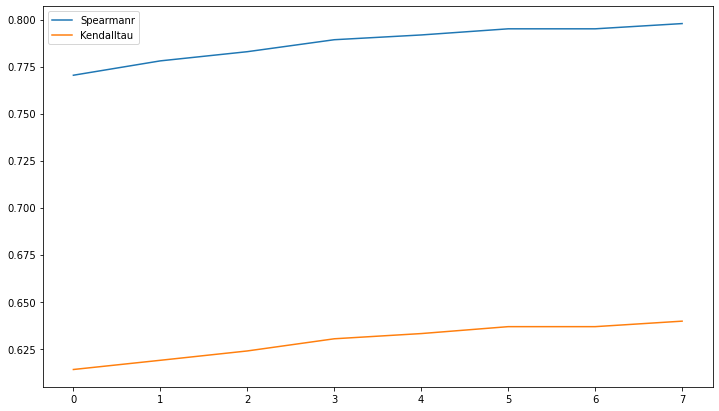

In [50]:
steps = 7
spearmanr_stats = [spearmanr_stat]
kendalltau_stats = [kendalltau_stat]
for step in range(steps):
    print(f'step: {step}')
    print('e_step')
    exp_z = e_step(baseline)
    print('m_step')
    m_step(baseline, exp_z)
    
    spearmanr_stat_temp, kendalltau_stat_temp = calculate_metrics(baseline.players_emb.weight.detach().cpu().numpy().flatten())
    spearmanr_stats.append(spearmanr_stat_temp)
    kendalltau_stats.append(kendalltau_stat_temp)
    
    clear_output(True)
    plt.figure(figsize=(12, 7))
    plt.plot(spearmanr_stats, label='Spearmanr')
    plt.plot(kendalltau_stats, label='Kendalltau')
    
    plt.legend()
    plt.show()

In [55]:
print(f'baseline: {spearmanr_stats[0]}, {kendalltau_stats[0]}')
print(f'EM: {spearmanr_stats[-1]}, {kendalltau_stats[-1]}')

baseline: 0.7703668123184415, 0.6138879535370674
EM: 0.7978347772941726, 0.6395969463804195


Теперь посмотрим рейтинг лист турниров на основе сложности вопросов, используя такую же формулу, как и для игроков

In [59]:
questions_complexity = baseline.questions_emb.weight.detach().cpu().numpy().flatten()

In [86]:
questions_complexity_df = pd.DataFrame(
    {
        'question': list(question_to_tournament.keys()),
        'complexity': questions_complexity,
        'tournament': [question_to_tournament[question] for question in question_to_tournament]
    }
)
questions_complexity_df = questions_complexity_df.merge(df_tournaments_train[['name', 'id']], how='inner', left_on='tournament', right_on='id').drop(columns='id')

In [87]:
questions_complexity_df.head()

,question,complexity,tournament,name
0,0,1.707806,6144,Из Минска с любовью. Этап 3
1,1,3.036494,6144,Из Минска с любовью. Этап 3
2,2,2.225022,6144,Из Минска с любовью. Этап 3
3,3,1.549804,6144,Из Минска с любовью. Этап 3
4,4,1.895689,6144,Из Минска с любовью. Этап 3


In [110]:
def calculate_complexity(df):
    calculate_complexity = np.sum(np.exp(df.complexity))
    
    return calculate_complexity

In [117]:
tournament_complixity = questions_complexity_df.groupby(['tournament', 'name']).apply(calculate_complexity).sort_values(ascending=False)

In [118]:
tournament_complixity.head(10)

tournament  name                                   
6149        Чемпионат Санкт-Петербурга. Первая лига    81923.601562
5465        Чемпионат России                           13936.476562
5795        Кубок Москвы                               11593.333984
6150        Чемпионат Санкт-Петербурга. Высшая лига    11423.669922
5025        Кубок городов                               9770.329102
5159        Первенство правого полушария                9035.180664
6090        Дзержинский марафон                         8904.393555
5928        Угрюмый Ёрш                                 8361.461914
6085        Серия Гран-при. Общий зачёт                 7822.415039
5669        Белые ночи                                  6623.321777
dtype: float32

In [119]:
tournament_complixity.tail(10)

tournament  name                                            
5698        (а)Синхрон-lite. Лига старта. Эпизод VII            104.083328
6003        Второй тематический турнир имени Джоуи Триббиани    103.581291
5876        (А) Славянка без раздаток. 4 этап                    99.503723
5704        (а)Синхрон-lite. Лига старта. Эпизод X               98.374435
5009        (а)Синхрон-lite. Лига старта. Эпизод III             97.977318
5749        Чемпионат Кипра среди школьников                     88.668488
5013        (а)Синхрон-lite. Лига старта. Эпизод V               88.071831
6131        ДР Земцовского                                       87.483574
5438        Синхрон Лиги Разума                                  86.229614
6102        One ring - async                                     67.415970
dtype: float32

Выглядит правдиво

P.S. Жаль что нет времени на доп задания, т.к. что-то все домашки решили провести в одно время :(